# Handlebodies via Lefschetz Bifibrations

To use this notebook, execute the code cells from top to bottom, tweaking whatever you need. The next field simply imports the necessary methods.

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from sage.all import *
from lefschetz import *

## The Domain

Define the affine variety you wish to study below. 

In [44]:
x,y,z = var('x, y, z', domain=CC)

alpha = var('alpha', domain=CC)
X = x*y*z + x^2 + y^2 + alpha*x + y # alpha in C^*
X = X.subs(alpha==1)

print(X)

x*y*z + x^2 + y^2 + x + y


A sanity check to make sure your affine variety is smooth.

In [3]:
# Check if X is smooth
X_vars = X.variables()
constraints = [X.diff(var) == 0 for var in X_vars]
solutions = solve(constraints, X_vars, solution_dict=True)
singularities = [point for point in solutions if X.subs(point).is_zero()]


if singularities:
    print(f"The variety is singular at the following points: {singularities}")
else:
    print("The variety is smooth.")

# Check if is_zero is reliable: Evaluate X at all points where all partial derivatives vanish, and be concerned if a value
# is close to 0.
for point in solutions:
    print(X.subs(point))


The variety is smooth.
-1/4
-1/4


## A Lefschetz Bifibration

### $\pi$

We start by defining the ''big'' fibration, which we refer to as $\pi: X \to \mathbb{C}$.

Adjust the coefficients of the fibration, as well as the point defining the reference fibre (this is the variable `origin_fibre`). The variable `solvefor` determines which of the variables $x,y,z$ is eliminated when solving for fibres.

The output consists of a plot of the critical values, an equation describing the fibre as an affine variety, as well as the number of critical values and points to make sure at most one critical point sits over each fibre.

The model fibre over 0 is {7/10*x^2*y - 3/10*I*x*y^2 + x^2 + y^2 + x + y == 0}
Critical values: 6 
Critical points: 6


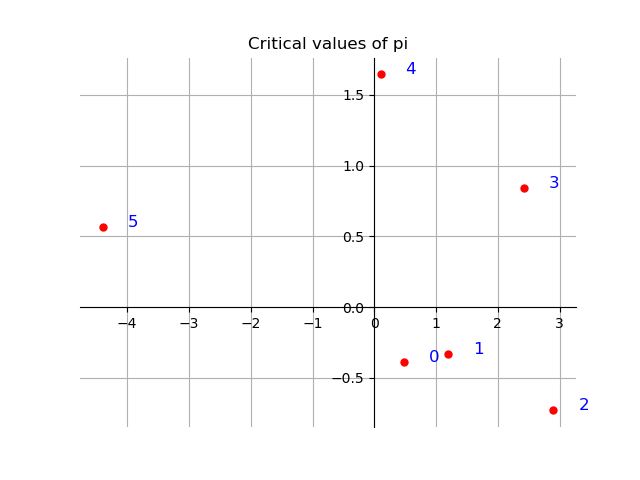

In [30]:
alpha, beta, gamma = var('alpha, beta, gamma', domain=CC)
pi = alpha*x + beta*y + gamma*z


pi = pi.subs({
    alpha: -0.7,
    beta: 0.3*I,
    gamma: 1
})

pi = LefschetzFibration([x,y,z], X, pi)

origin_fibre = 0
solvefor=z

print(f'The model fibre over {origin_fibre} is {{{pi.get_fibre(origin_fibre, solvefor).expand()} == 0}}')

crit_values_pi = sort_by_angle(pi.get_critical_values(), origin_fibre)
crit_points_pi = pi.get_critical_points()

print(f'Critical values: {len(crit_values_pi)} \nCritical points: {len(crit_points_pi)}')


plot_points_ordered(crit_values_pi,origin_fibre, title='Critical values of pi')

If you are unhappy with the distribution of critical values and would like to experiment with different parameter values, you can evaluate the above for a path of parameters. `pl_path` creates a piecewise linear path joining the numbers in the argument list.

In [5]:
steps=100

a_path = pl_path([0.3, 0.4, 0.5], steps=steps)
b_path = pl_path([0.1*I, I], steps=steps)
c_path = pl_path([1, 0.1, 2, 4, 6], steps=steps)



pi_params = {'a': a_path, 'b': b_path, 'c': c_path}


crits = parameterized_fib_crits(pi, pi_params)
plot_paths(crits)

KeyboardInterrupt: ECL says: Console interrupt.

The next cell computes the intersection of $\pi^{-1}(0)$ with the hyperplane at infinity  in the projectivization $\bar{X}$ of $X$. If this intersection is transverse, this presents $\pi$ as the restriction to $X$ of a Lefschetz pencil on $\bar{X}$, establishing the existence of parallel transport maps, and thereby ruling out singularities at infinity.

To check whether the intersection is transverse, we compute $\nabla \bar{X}$, $\nabla \pi$, and $\nabla w$, where $w$ is the homogenization variable. If these three vectors are linearly independent, then $\ker d \pi$ and $\ker d w$ span $\ker d \bar{X}$. Concretely, we form the matrix
$$ M = \left(\begin{matrix} \frac{\partial \bar{X}}{\partial x} & \frac{\partial \bar{X}}{\partial y} & \frac{\partial \bar{X}}{\partial z} & \frac{\partial \bar{X}}{\partial w} \\
    \alpha & \beta & \gamma & 0\\
    0& 0& 0& 1 \end{matrix}\right),
$$ 
and compute its rank at every intersection point. If the rank is 3, the intersection is transverse.

In [7]:
intersection = pi.get_fibre_boundary_components(point=origin_fibre, variable=solvefor)


print(f'The zero locus of pi intersects the hyperplane at infinity at \n {intersection}.\n')

print(f'The general fibre of pi hence has {len(intersection)} punctures.\n')


pi.transversality_at_infinity(origin_fibre=origin_fibre, variable=solvefor)

domain_hom = pi.get_homogenized_domain()
print(f'\nThe homogenized domain is \nXbar = {domain_hom}.')

hom_singularities = set_free_variable_to_one_list(singular_points(domain_hom))

if hom_singularities:
    print(f'\nThe homogenized domain has singularities at {hom_singularities}.')
else:
    print('The homogenized domain is smooth.')


The zero locus of pi intersects the hyperplane at infinity at 
 [{x: 0, y: 1, z: -3/10*I, w: 0}, {x: 1, y: 0, z: 7/10, w: 0}, {x: 1, y: -7/3*I, z: 0, w: 0}].

The general fibre of pi hence has 3 punctures.

The rank of M at {x: 0, y: 1, z: -3/10*I, w: 0} is 3.
The rank of M at {x: 1, y: 0, z: 7/10, w: 0} is 3.
The rank of M at {x: 1, y: -7/3*I, z: 0, w: 0} is 3.

The homogenized domain is 
Xbar = 1.00000000000000*w^2*x + 1.00000000000000*w*x^2 + 1.00000000000000*w^2*y + 1.00000000000000*w*y^2 + 1.00000000000000*x*y*z.

The homogenized domain has singularities at [{w: 0, x: 0, y: 0, z: 1}].


### $\rho$

Define the ''small'' Lefschetz fibration $\rho$, interpreted as a collection of Lefschetz fibrations $\rho_z: \pi^{-1}(z) \to \mathbb{C}$. Effectively, we need only specify a linear polynomial in the two remaining variables.

Specify the coefficients `ar` and `br`, as well as the reference fibre `origin_fibre_rho` for $\rho_{x_0}: \pi^{-1}(x_0) \to \mathbb{C}$, where $x_0$ is `origin_fibre`.

rho(x,y,z) = x - 0.0500000000000000*I*y
The reference fibre of rho_0 over 0 is 
{53/4000*y^3 + 399/400*y^2 + (1/20*I + 1)*y == 0}.
Critical values: 6
Critical points: 6


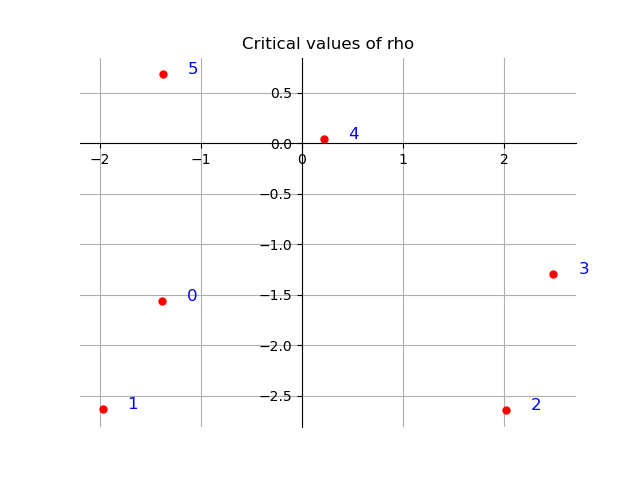

In [45]:
ar, br = var('ar, br', domain=CC)
variables_rho = [x,y,z]
variables_rho.remove(solvefor)
x_rho = variables_rho[0]
y_rho = variables_rho[1]

rho = ar*x_rho + br*y_rho

rho = rho.subs({
    ar: 1,
    br: -0.05*I
})
print(f'rho(x,y,z) = {rho}')

origin_fibre_rho = 0
solvefor_rho = x_rho

rho_0 = LefschetzFibration(variables_rho, pi.get_fibre(origin_fibre, solvefor), rho)

crit_points_rho = rho_0.get_critical_points()
crit_values_rho = sort_by_angle(rho_0.get_critical_values(), origin_fibre_rho)

ref_fibre = rho_0.get_fibre(origin_fibre_rho, solvefor_rho).expand() 

print(f'The reference fibre of rho_0 over {origin_fibre_rho} is \n{{{ref_fibre} == 0}}.')
print(f'Critical values: {len(crit_values_rho)}')
print(f'Critical points: {len(crit_points_rho)}')

plot_points_ordered(crit_values_rho, origin_fibre_rho, title='Critical values of rho')



You can again create parametric versions of this picture.

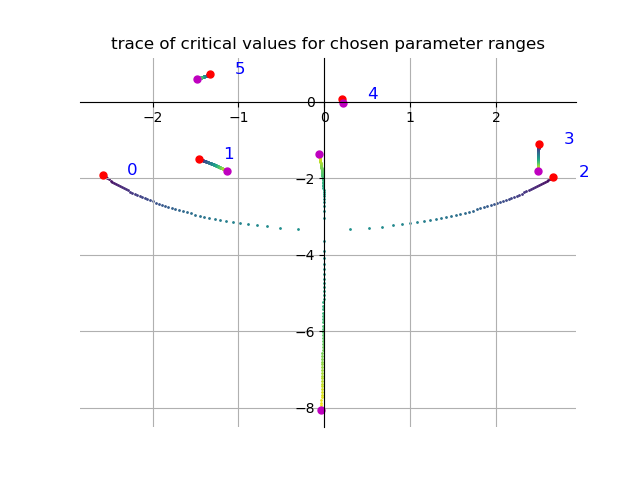

In [24]:
steps=100

ar_path = pl_path([1], steps=steps)
br_path = pl_path([-0.1*I,0.1*I], steps=steps)


rho_params = {'a': ar_path, 'b': br_path}


crits = parameterized_fib_crits(rho_0, rho_params)
plot_paths(crits)

#### Vanishing Cycles of $\rho$

In the next cell, we visualize the reference fibre of $\rho_0$, which consists of a number of discrete points in $\pi^{-1}(x_0)$. The points below are obtained by solving $a_r x_\text{rho} + b_r y_\text{rho} = \text{origin fibre rho}$ for `solvefor_rho`, substituting into the equation for $\pi^{-1}(0)$, which yields a univariate polynomial, and then plotting the roots of that polynomial.

The fibre of rho_0 over 0 is described by 
53/4000*y^3 + 399/400*y^2 + (1/20*I + 1)*y == 0.


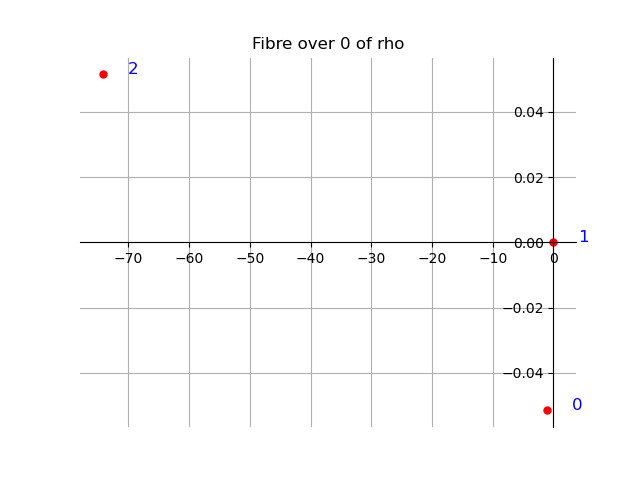

In [46]:
print(f'The fibre of rho_0 over {origin_fibre_rho} is described by \n{ref_fibre} == 0.')

sols = NumericalRoots(ref_fibre)

plot_points_ordered(sols, origin_fibre_rho, title=f"Fibre over {origin_fibre_rho} of rho")

To be able to determine a basis of matching paths, one needs to know the vanishing cycles of $\rho$. In this dimension, these can be determined by following along the fibre of $\rho_t$ for $t$ in a vanishing path for $\pi$, and seeing which two critical values come together.

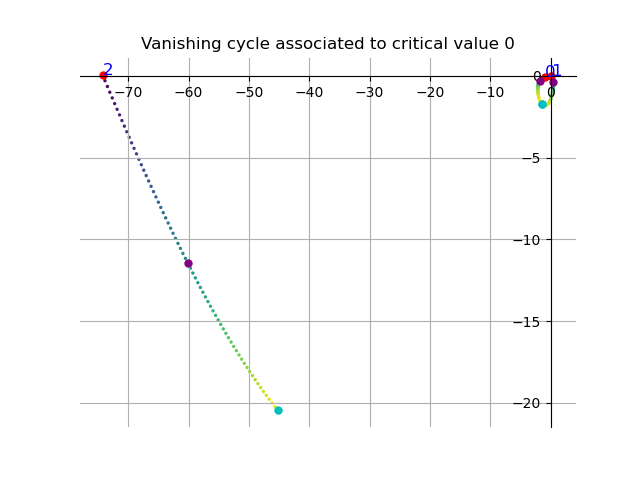

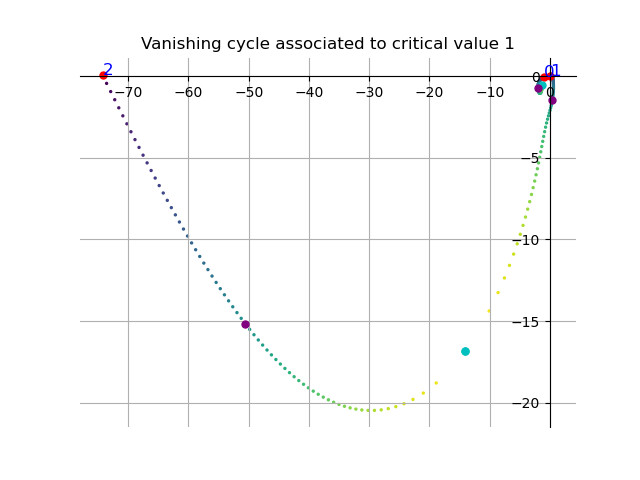

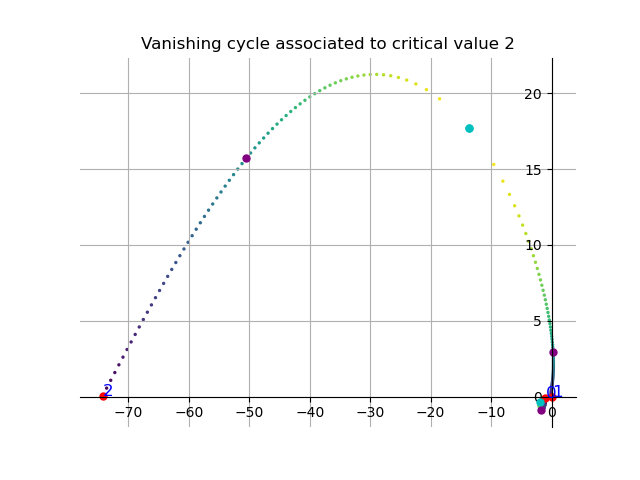

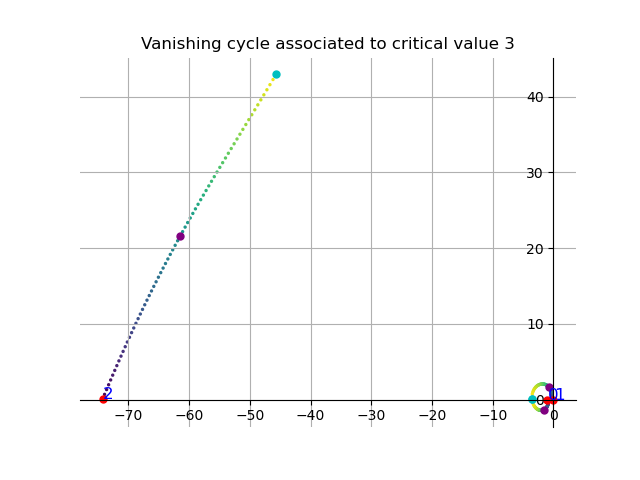

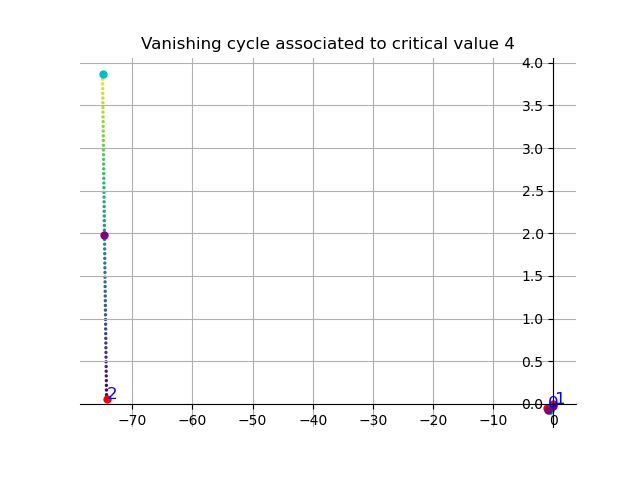

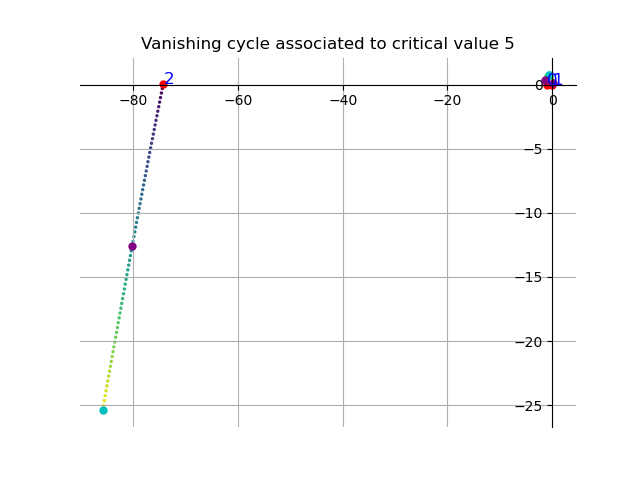

In [47]:
for (index, point) in enumerate(crit_values_rho):
    path = pl_path([origin_fibre_rho, point])
    trace_preimage(rho_0, path, origin_fibre_rho, solvefor=solvefor_rho, title=f'Vanishing cycle associated to critical value {index}')    

When looking for a basis of matching paths, you may be interested in the behaviour of parallel transport along more general paths. 

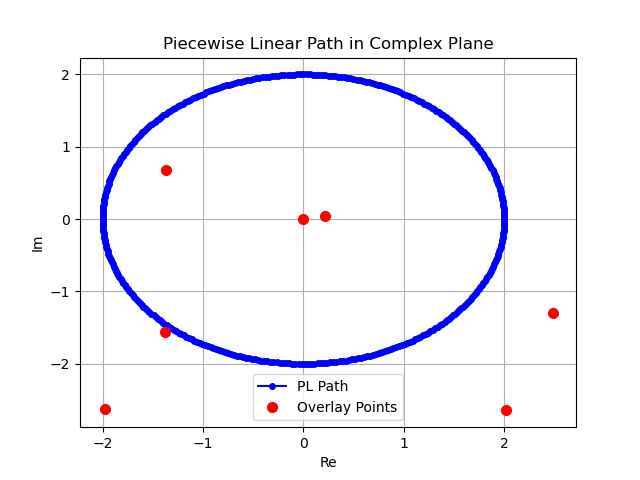

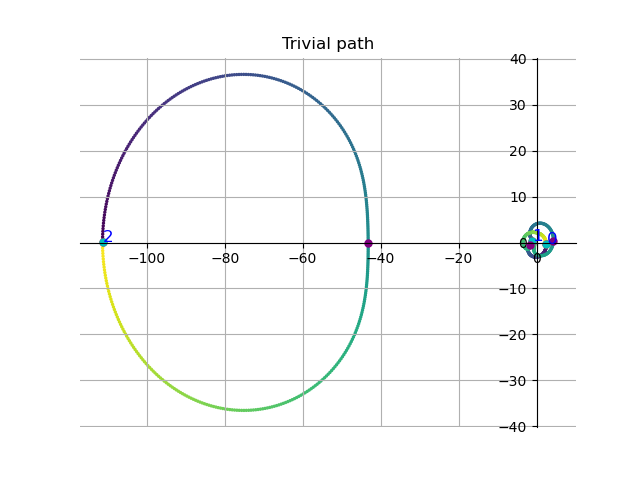

In [44]:
r=2
z=0
trivial_path = [r*np.sin(s) + I*r*np.cos(s) + z for s in np.linspace(0, 2*np.pi, 400)]
plot_pl_path(trivial_path, spec_points=crit_values_rho+[complex(0)])
fig, ax = trace_preimage(rho_0, trivial_path, origin_fibre_rho, title='Trivial path')
plt.show()

## Matching Paths for $\rho$ =  Vanishing Cycles for $\pi$

The final computation consists in tracing the critical values of $\rho_t$ for $t$ in a vanishing path $\gamma$ for $\pi$. These critical values will evolve, and two of them will collide at the critical value. 

The vertical direction in the graphs below describes $t \in [0,1]$, and each $\{t=const.\}$-slice describes the critical values of $\rho_t: \pi^{-1}(\gamma(t)) \to \mathbb{C}$.

By default, the vanishing paths $\gamma$ consist of a straight line from `origin_fibre` to the critical values of $\pi$; You can pass any path you like, and easily create some simple ones via the `pl_path` function, which takes as input a list of points, and outputs a piecewise linear path joining those points in order.

In [ ]:
pi_rho = Bifibration(pi, rho_0)

for index, crit in enumerate(crit_values_pi):
    path = pl_path([origin_fibre, crit], steps=70)
    matching = pi_rho.get_matching_path(path=path, solvefor=solvefor, steps=70)
    plot_path_3d(matching, origin_fibre=origin_fibre_rho, title = f'Matching path to critical value {index} of f')

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object

Graphics3d Object

Observe in the cells below two choices of vanishing paths isotopic in $\mathbb{C} \setminus \mathrm{Critval}(\pi)$ for $\pi$ which result in non-isotopic matching paths. This suggests the presence of a **fake** critical value in the terminology of Seidel. The associated matching cycles are (framed) Lagrangian isotopic.

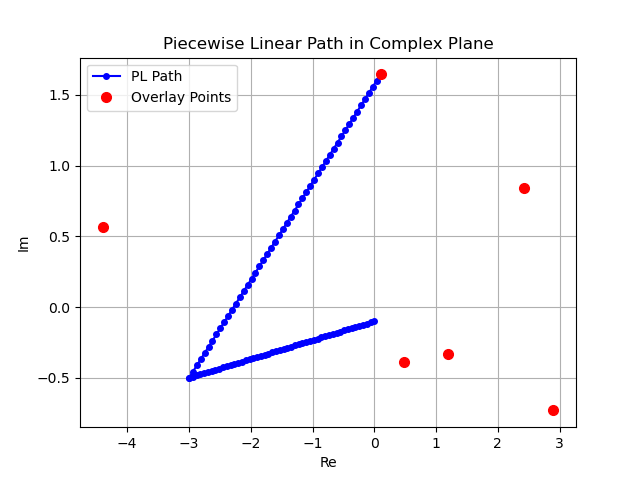

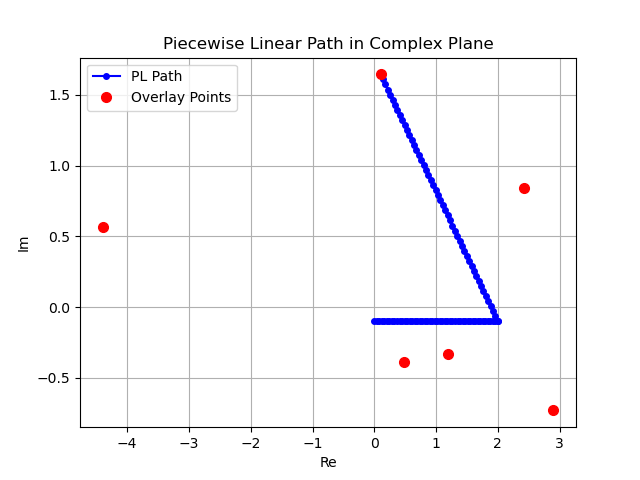

Graphics3d Object

Graphics3d Object

In [49]:
half_1 = pl_path([-0.1*I, -3-0.5*I, crit_values_pi[4]], steps=100)
half_2 = pl_path([-0.1*I, 2-0.1*I, crit_values_pi[4]], steps=100)

plot_pl_path(half_1, spec_points=crit_values_pi)
plot_pl_path(half_2, spec_points=crit_values_pi)
matching_1 = pi_rho.get_matching_path(path=half_1, solvefor=solvefor)
matching_2 = pi_rho.get_matching_path(path=half_2, solvefor=solvefor)
plot_path_3d(matching_1, origin_fibre=0, title = f'Matching path to critical value {4} of f')
plot_path_3d(matching_2, origin_fibre=0, title = f'Matching path to critical value {4} of f')